Загрузка и первичный обзор











In [20]:
import pandas as pd
import numpy as np

#Загрузка данных
df = pd.read_csv('games.csv')

#Первые строки
print("Первые 5 строк:")
print(df.head())

#Последние строки
print("\nПоследние 5 строк:")
print(df.tail())

#Структура данных
print("\nИнформация о датафрейме:")
print(df.info())

#Размер датасета
print(f"\nРазмер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")


print(df.info())

Первые 5 строк:
   Unnamed: 0                                    Title  Release Date  \
0           0                               Elden Ring  Feb 25, 2022   
1           1                                    Hades  Dec 10, 2019   
2           2  The Legend of Zelda: Breath of the Wild  Mar 03, 2017   
3           3                                Undertale  Sep 15, 2015   
4           4                            Hollow Knight  Feb 24, 2017   

                                                Team  Rating Times Listed  \
0     ['Bandai Namco Entertainment', 'FromSoftware']     4.5         3.9K   
1                               ['Supergiant Games']     4.3         2.9K   
2  ['Nintendo', 'Nintendo EPD Production Group No...     4.4         4.3K   
3                                 ['tobyfox', '8-4']     4.2         3.5K   
4                                    ['Team Cherry']     4.4           3K   

  Number of Reviews                                             Genres  \
0             

Проверка типов данных

In [21]:
print("Типы данных:")
print(df.dtypes)

#Преобразование числовых колонок (удаление 'K' и преобразование в float)
def convert_k_to_number(x):
    if isinstance(x, str):
        if 'K' in x:
            return float(x.replace('K', '')) * 1000
        else:
            try:
                return float(x)
            except:
                return x
    return x

#Применяем преобразование к колонкам с числовыми значениями
numeric_cols = ['Plays', 'Playing', 'Backlogs', 'Wishlist']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_k_to_number)

#Преобразование в числовой тип
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

#Проверка типов после преобразования
print("Типы данных после преобразования:")
print(df[numeric_cols].dtypes)

Типы данных:
Unnamed: 0             int64
Title                 object
Release Date          object
Team                  object
Rating               float64
Times Listed          object
Number of Reviews     object
Genres                object
Summary               object
Reviews               object
Plays                 object
Playing               object
Backlogs              object
Wishlist              object
dtype: object
Типы данных после преобразования:
Plays       float64
Playing     float64
Backlogs    float64
Wishlist    float64
dtype: object


1. Пропущенные значения

In [22]:
import matplotlib.pyplot as plt

print("Пропущенные значения по столбцам:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

#Удаление строк с пропусками в важных колонках
print(f"Размер датасета до удаления пропусков: {df.shape}")
df_clean = df.dropna(subset=['Title', 'Rating', 'Genres'])
print(f"Размер датасета после удаления пропусков: {df_clean.shape}")

#Заполнение пропусков в числовых колонках медианой
numeric_cols_for_fill = ['Rating', 'Times Listed', 'Number of Reviews'] + numeric_cols
for col in numeric_cols_for_fill:
    if col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"Заполнено {col} медианой: {median_val}")

Пропущенные значения по столбцам:
Team        1
Rating     13
Summary     1
dtype: int64
Размер датасета до удаления пропусков: (1512, 14)
Размер датасета после удаления пропусков: (1499, 14)


2. Дубликаты

In [25]:
print(f"\nКоличество дубликатов: {df_clean.duplicated().sum()}")
print(f"Дубликаты по Title: {df_clean['Title'].duplicated().sum()}")

#Удаление дубликатов по Title
df_clean = df_clean.drop_duplicates(subset=['Title'], keep='first')
print(f"Размер после удаления дубликатов: {df_clean.shape}")


Количество дубликатов: 0
Дубликаты по Title: 0
Размер после удаления дубликатов: (1086, 14)


3. Выбросы


Поиск выбросов с помощью z-score:
Rating: 10 выбросов
Plays: 19 выбросов
Playing: 20 выбросов
Backlogs: 27 выбросов
Wishlist: 25 выбросов


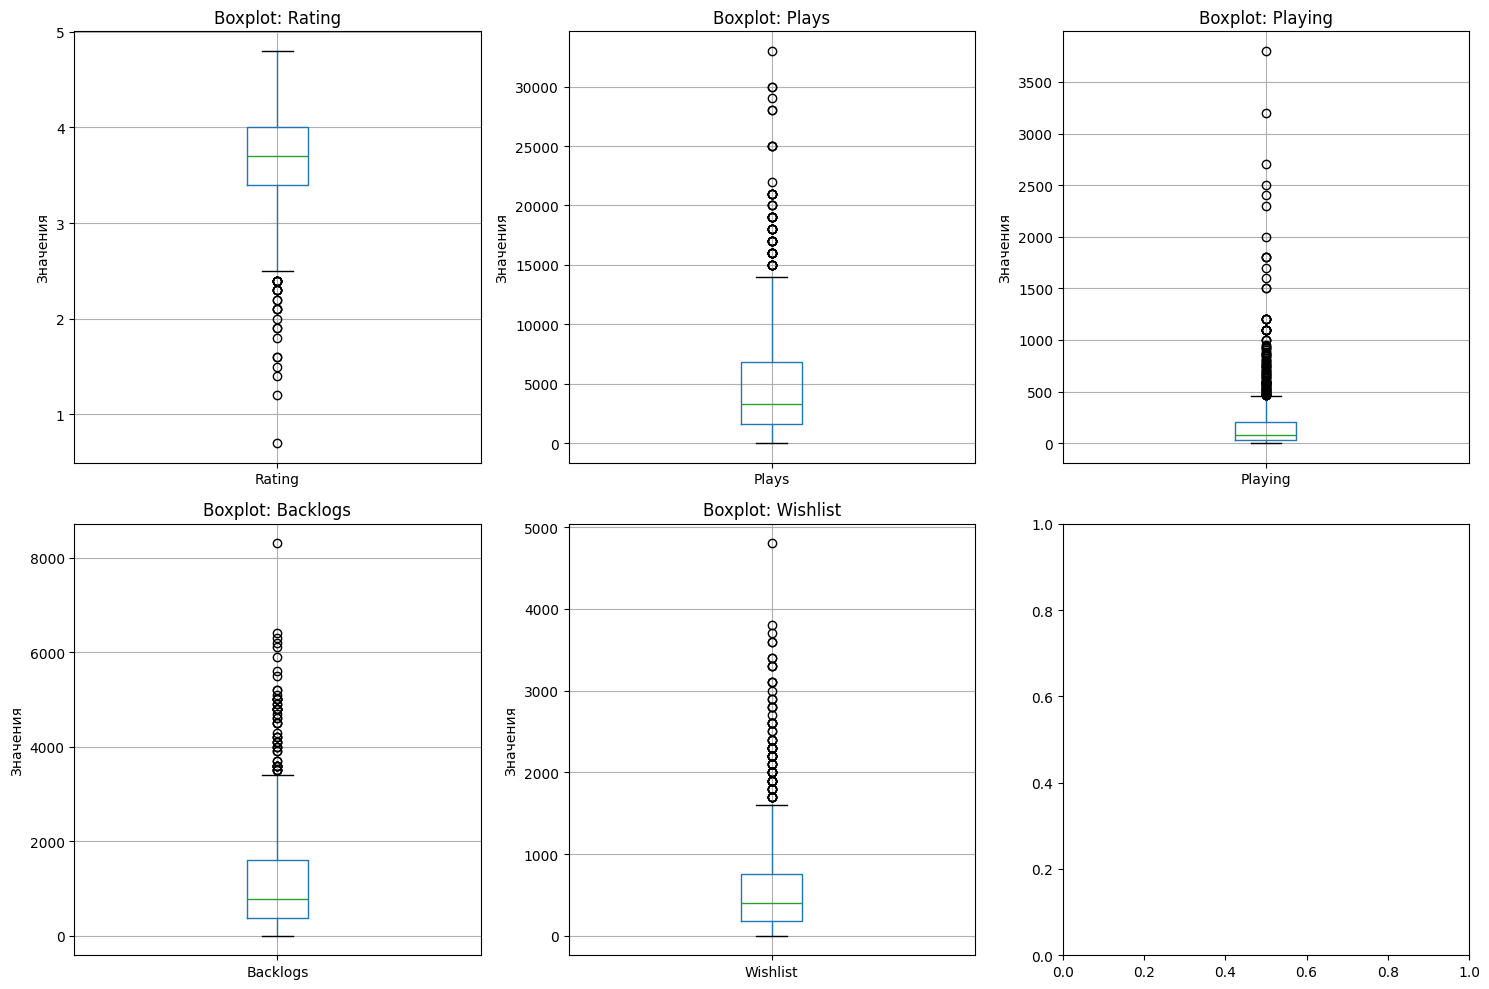

In [26]:
import numpy as np
import matplotlib.pyplot as plt

print("\nПоиск выбросов с помощью z-score:")

#Для числовых колонок
numeric_columns = ['Rating', 'Plays', 'Playing', 'Backlogs', 'Wishlist']
outliers_info = {}

for col in numeric_columns:
    if col in df_clean.columns:
        #Вычисляем Z-score вручную
        mean_val = df_clean[col].dropna().mean()
        std_val = df_clean[col].dropna().std()
        if std_val > 0:
            z_scores = np.abs((df_clean[col].dropna() - mean_val) / std_val)
            outliers = df_clean[z_scores > 3]
            outliers_info[col] = len(outliers)
            print(f"{col}: {len(outliers)} выбросов")
        else:
            print(f"{col}: Стандартное отклонение равно 0, выбросы не применимы.")

#Визуализация выбросов с помощью boxplot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_columns[:6]):
    if col in df_clean.columns:
        df_clean.boxplot(column=col, ax=axes[idx])
        axes[idx].set_title(f'Boxplot: {col}')
        axes[idx].set_ylabel('Значения')

plt.tight_layout()
plt.show()

#Обработка выбросов - замена на граничные значения
for col in numeric_columns:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        #Замена выбросов
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

Статистики данных

In [27]:
print("Описательная статистика числовых колонок:")
print(df_clean.describe())

#Уникальные значения для категориальных колонок
print("\nУникальные значения в категориальных колонках:")
categorical_cols = ['Title', 'Team', 'Genres', 'Summary']
for col in categorical_cols:
    if col in df_clean.columns:
        print(f"\n{col}:")
        print(f"  Количество уникальных значений: {df_clean[col].nunique()}")
        if df_clean[col].nunique() < 10:
            print(f"  Уникальные значения: {df_clean[col].unique()}")

#Частота встречаемости жанров
if 'Genres' in df_clean.columns:
    #Преобразование строк с жанрами в списки
    df_clean['Genres_list'] = df_clean['Genres'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )

    #Создание списка всех жанров
    all_genres = []
    for genres in df_clean['Genres_list'].dropna():
        if isinstance(genres, list):
            all_genres.extend(genres)

    #Подсчет частоты
    from collections import Counter
    genre_counts = Counter(all_genres)
    print("\nТоп-10 жанров:")
    for genre, count in genre_counts.most_common(10):
        print(f"  {genre}: {count} игр")

#Корреляционный анализ
print("\nКорреляционная матрица (числовые колонки):")
correlation_matrix = df_clean[numeric_columns].corr()
print(correlation_matrix)

Описательная статистика числовых колонок:
        Unnamed: 0       Rating         Plays      Playing    Backlogs  \
count  1086.000000  1086.000000   1086.000000  1086.000000  1086.00000   
mean    789.032228     3.666667   4772.126151   141.192680  1118.44360   
std     481.230956     0.503164   4171.571658   143.416386   951.89766   
min       0.000000     2.500000      1.000000     0.000000     5.00000   
25%     275.250000     3.400000   1600.000000    34.000000   388.25000   
50%     845.500000     3.700000   3300.000000    82.000000   774.00000   
75%    1213.500000     4.000000   6800.000000   202.750000  1600.00000   
max    1511.000000     4.800000  14600.000000   455.875000  3417.62500   

          Wishlist  
count  1086.000000  
mean    548.966851  
std     477.678492  
min       2.000000  
25%     178.000000  
50%     401.500000  
75%     760.000000  
max    1633.000000  

Уникальные значения в категориальных колонках:

Title:
  Количество уникальных значений: 1086

Team:


Визуализация данных

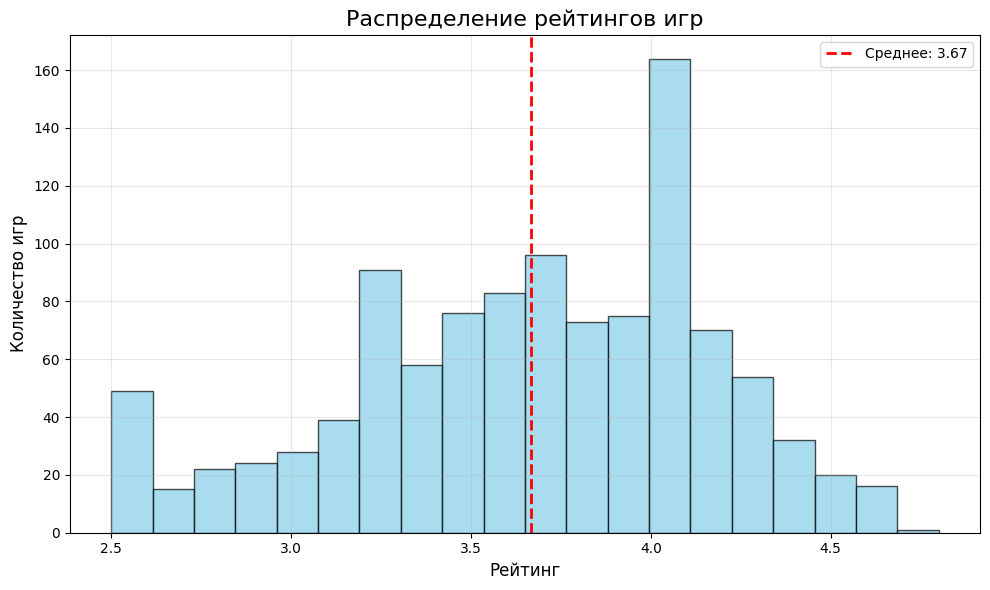

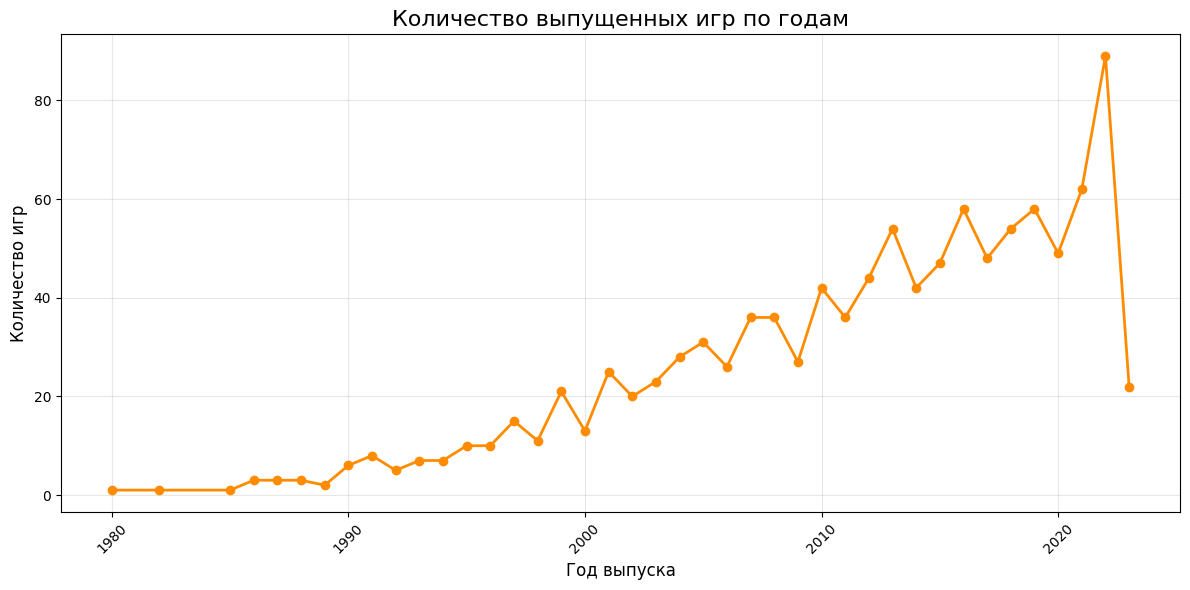

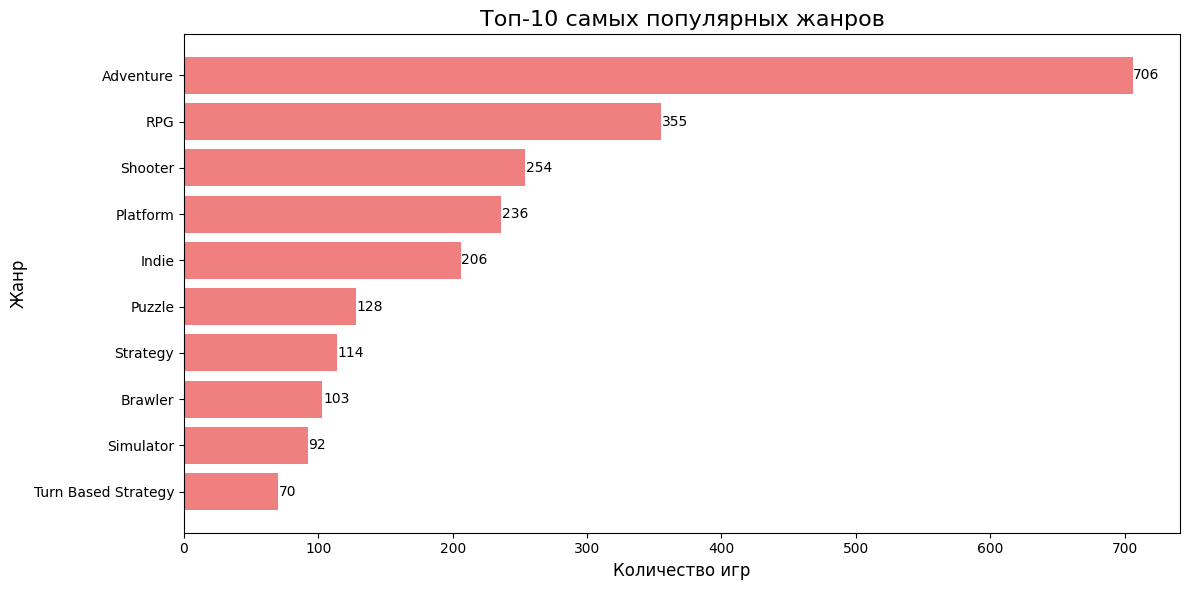

/tmp/ipython-input-344787525.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=top_5_genres, patch_artist=True)


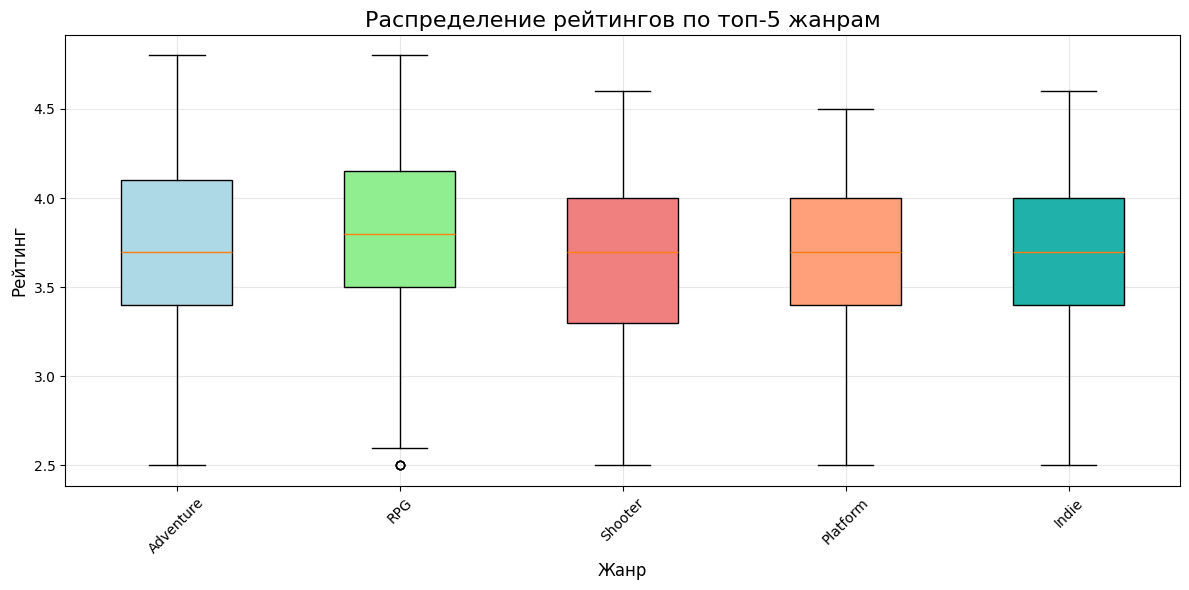

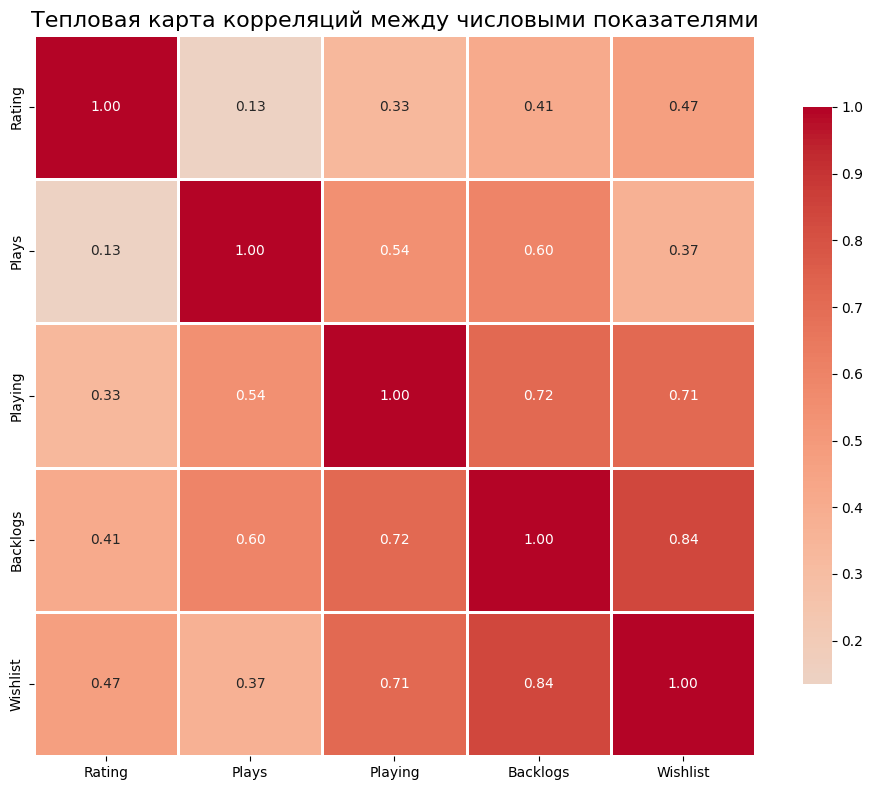

In [28]:
import seaborn as sns

#1. Гистограмма распределения рейтингов
plt.figure(figsize=(10, 6))
plt.hist(df_clean['Rating'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Распределение рейтингов игр', fontsize=16)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(df_clean['Rating'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {df_clean["Rating"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

#2. Линейный график: количество выпущенных игр по годам
#Извлекаем год из Release Date
df_clean['Release_Year'] = pd.to_datetime(df_clean['Release Date'], errors='coerce').dt.year

#Группировка по годам
games_by_year = df_clean.groupby('Release_Year').size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
plt.plot(games_by_year['Release_Year'], games_by_year['Count'],
         marker='o', linewidth=2, markersize=6, color='darkorange')
plt.title('Количество выпущенных игр по годам', fontsize=16)
plt.xlabel('Год выпуска', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#3. Столбчатая диаграмма: топ-10 самых популярных жанров
top_genres = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count'])

plt.figure(figsize=(12, 6))
bars = plt.barh(top_genres['Genre'], top_genres['Count'], color='lightcoral')
plt.title('Топ-10 самых популярных жанров', fontsize=16)
plt.xlabel('Количество игр', fontsize=12)
plt.ylabel('Жанр', fontsize=12)

#Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center')

plt.gca().invert_yaxis()  # Инвертируем ось Y для отображения от большего к меньшему
plt.tight_layout()
plt.show()

#4. Boxplot для сравнения распределения оценок по топ-5 жанрам
#Находим топ-5 жанров
top_5_genres = [genre for genre, _ in genre_counts.most_common(5)]

#Создаем датафрейм для boxplot
boxplot_data = []
for genre in top_5_genres:
    #Находим игры этого жанра
    genre_games = df_clean[df_clean['Genres_list'].apply(
        lambda x: genre in x if isinstance(x, list) else False
    )]
    ratings = genre_games['Rating'].dropna().tolist()
    boxplot_data.append(ratings)

plt.figure(figsize=(12, 6))
box = plt.boxplot(boxplot_data, labels=top_5_genres, patch_artist=True)

#Раскрашиваем boxplot
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Распределение рейтингов по топ-5 жанрам', fontsize=16)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Рейтинг', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#5. Heatmap корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            center=0, linewidths=1, linecolor='white',
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Тепловая карта корреляций между числовыми показателями', fontsize=16)
plt.tight_layout()
plt.show()

Группировки и агрегации

Средний рейтинг по жанрам (топ-10):
  Visual Novel: 3.97
  Turn Based Strategy: 3.82
  RPG: 3.78
  Tactical: 3.75
  Puzzle: 3.75
  Adventure: 3.71
  Brawler: 3.67
  Indie: 3.66
  Point-and-Click: 3.66
  Platform: 3.65


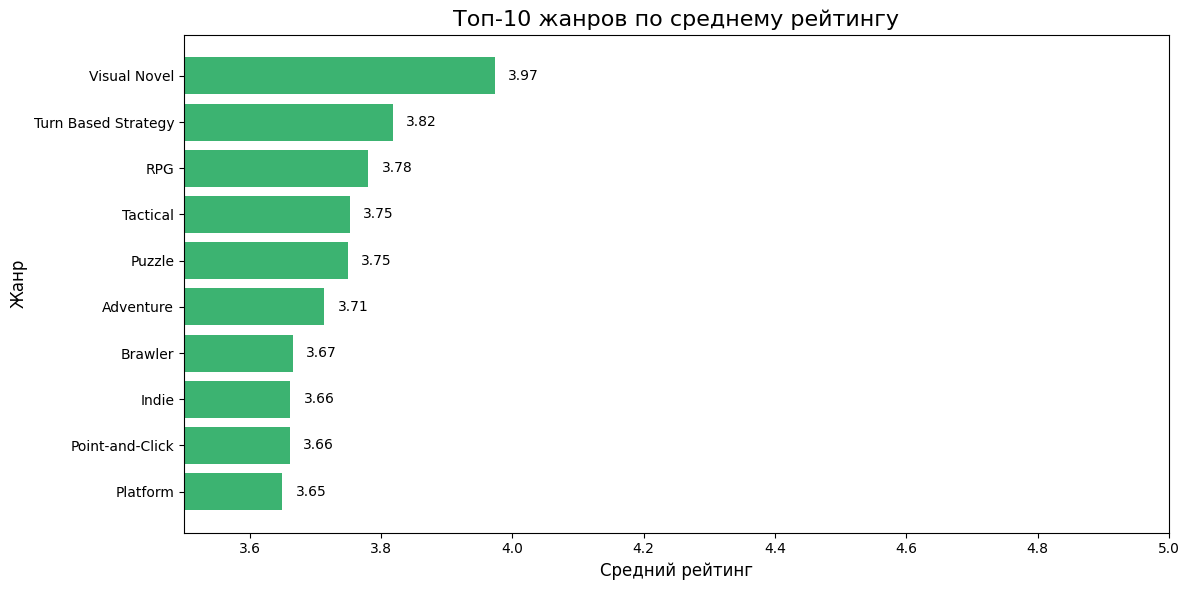


Количество игр по годам (топ-10):
 Release_Year  Count
       2022.0     89
       2021.0     62
       2016.0     58
       2019.0     58
       2018.0     54
       2013.0     54
       2020.0     49
       2017.0     48
       2015.0     47
       2012.0     44

Топ-10 команд по количеству игр:
  Nintendo: 169 игр
  Capcom: 62 игр
  Square Enix: 55 игр
  Sega: 43 игр
  Electronic Arts: 41 игр
  Konami: 31 игр
  Activision: 29 игр
  Bandai Namco Entertainment: 27 игр
  Ubisoft Entertainment: 27 игр
  Atlus: 23 игр

Сводная таблица по годам:
 Release_Year  Game_Count  Avg_Rating  Total_Plays
       2023.0          22    3.595455      13045.0
       2022.0          89    3.647191     142234.0
       2021.0          62    3.732258     192324.0
       2020.0          49    3.789796     245638.0
       2019.0          58    3.725862     304861.0
       2018.0          54    3.766667     285773.0
       2017.0          48    3.614583     298119.0
       2016.0          58    3.627586     

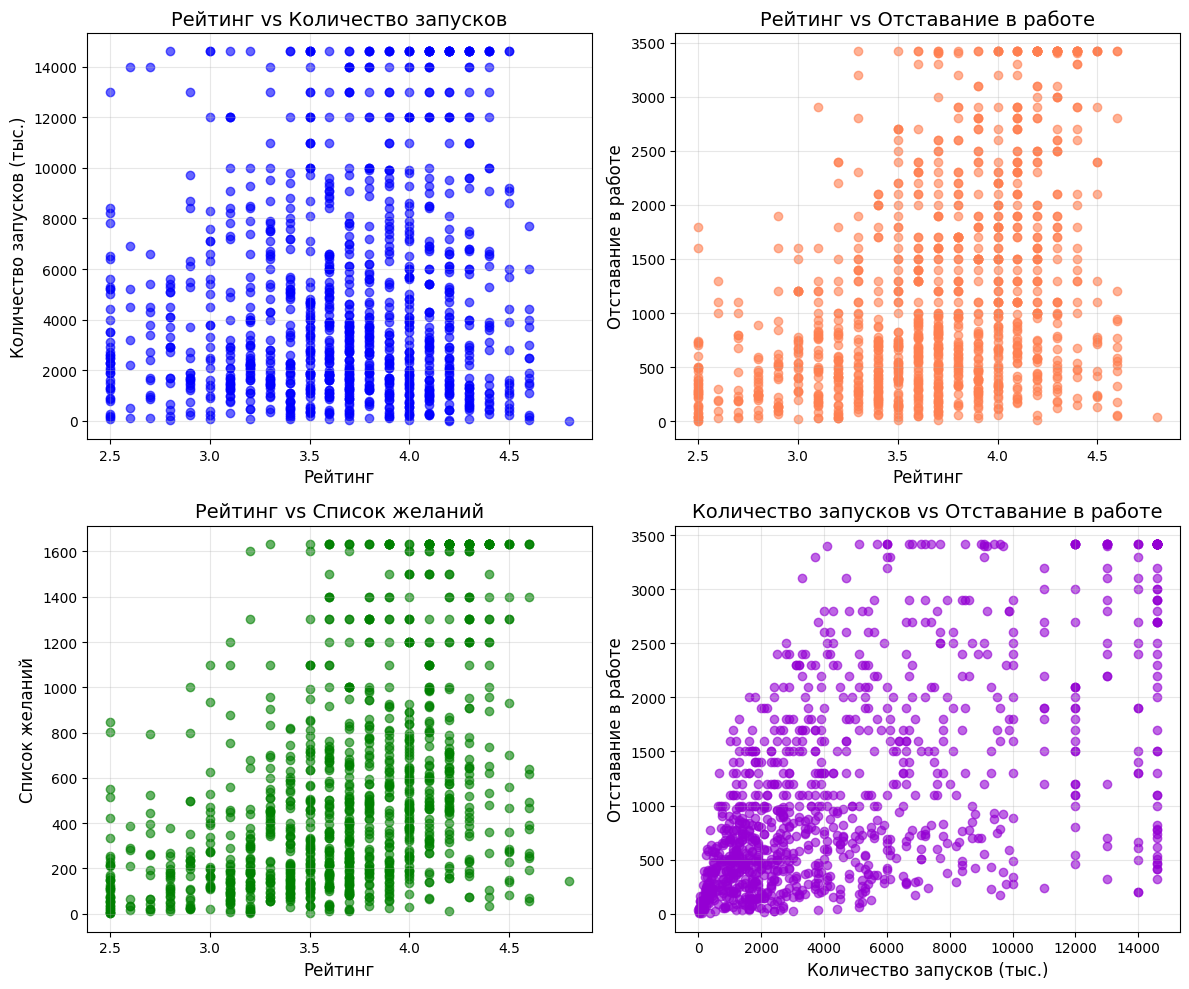

In [29]:
#1. Средний рейтинг по жанрам (топ-10)
print("Средний рейтинг по жанрам (топ-10):")

genre_ratings = {}
for genre in list(genre_counts.keys())[:20]:
    genre_games = df_clean[df_clean['Genres_list'].apply(
        lambda x: genre in x if isinstance(x, list) else False
    )]
    if len(genre_games) >= 3:
        avg_rating = genre_games['Rating'].mean()
        genre_ratings[genre] = avg_rating

#Сортируем по рейтингу
sorted_genre_ratings = sorted(genre_ratings.items(), key=lambda x: x[1], reverse=True)[:10]

for genre, rating in sorted_genre_ratings:
    print(f"  {genre}: {rating:.2f}")

#Визуализация среднего рейтинга по жанрам
top_genre_ratings = pd.DataFrame(sorted_genre_ratings, columns=['Genre', 'Avg_Rating'])

plt.figure(figsize=(12, 6))
bars = plt.barh(top_genre_ratings['Genre'], top_genre_ratings['Avg_Rating'],
                color='mediumseagreen')
plt.title('Топ-10 жанров по среднему рейтингу', fontsize=16)
plt.xlabel('Средний рейтинг', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.xlim([3.5, 5.0])

#Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', ha='left', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#2. Количество игр по годам (агрегация)
print("\nКоличество игр по годам (топ-10):")
top_years = games_by_year.sort_values('Count', ascending=False).head(10)
print(top_years.to_string(index=False))

#3. Суммарные показатели активности по командам (топ-10)
if 'Team' in df_clean.columns:
    #Преобразуем Team в список
    df_clean['Team_list'] = df_clean['Team'].apply(
        lambda x: eval(x) if isinstance(x, str) else []
    )

    #Создаем список всех команд
    all_teams = []
    for teams in df_clean['Team_list'].dropna():
        all_teams.extend(teams)

    #Подсчитываем игры по командам
    from collections import Counter
    team_counts = Counter(all_teams)

    print("\nТоп-10 команд по количеству игр:")
    for team, count in team_counts.most_common(10):
        print(f"  {team}: {count} игр")

#4. Сводная таблица: средний рейтинг и количество игр по годам
pivot_table = df_clean.groupby('Release_Year').agg(
    Game_Count=('Title', 'count'),
    Avg_Rating=('Rating', 'mean'),
    Total_Plays=('Plays', 'sum')
).reset_index()

print("\nСводная таблица по годам:")
print(pivot_table.sort_values('Release_Year', ascending=False).head(10).to_string(index=False))

#5. Анализ взаимосвязи рейтинга и активности
print("\nКорреляция рейтинга с показателями активности:")
correlations = df_clean[['Rating', 'Plays', 'Playing', 'Backlogs', 'Wishlist']].corr()['Rating']
print(correlations.drop('Rating'))

#Визуализация взаимосвязи рейтинга и количества игр
plt.figure(figsize=(12, 10))

#Точечный график: Rating vs Plays
plt.subplot(2, 2, 1)
plt.scatter(df_clean['Rating'], df_clean['Plays'], alpha=0.6, color='blue')
plt.title('Рейтинг vs Количество запусков', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Количество запусков (тыс.)', fontsize=12)
plt.grid(True, alpha=0.3)

#Точечный график: Rating vs Backlogs
plt.subplot(2, 2, 2)
plt.scatter(df_clean['Rating'], df_clean['Backlogs'], alpha=0.6, color='coral')
plt.title('Рейтинг vs Отставание в работе', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Отставание в работе', fontsize=12)
plt.grid(True, alpha=0.3)

#Точечный график: Rating vs Wishlist
plt.subplot(2, 2, 3)
plt.scatter(df_clean['Rating'], df_clean['Wishlist'], alpha=0.6, color='green')
plt.title('Рейтинг vs Список желаний', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Список желаний', fontsize=12)
plt.grid(True, alpha=0.3)

#Точечный график: Plays vs Backlogs
plt.subplot(2, 2, 4)
plt.scatter(df_clean['Plays'], df_clean['Backlogs'], alpha=0.6, color='darkviolet')
plt.title('Количество запусков vs Отставание в работе', fontsize=14)
plt.xlabel('Количество запусков (тыс.)', fontsize=12)
plt.ylabel('Отставание в работе', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()